# Model Evaluation

This notebook will contain code that will be useful for determining the effectiveness of the produced models.

Largest connected component

In [1]:
import os
import glob
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadNiftid, ScaleIntensityd, AddChanneld, ToTensord, RandSpatialCropd, CenterSpatialCropd, CropForegroundd, NormalizeIntensityd, RandCropByPosNegLabeld, Identityd
# from MONAIUNet import UNet
from t4_3dUNet import UNet


In [2]:
# Models:
# 'models/6-8-2020_Test/tb_logs/6-8-2020_Test/version_0/checkpoints/epoch=714.ckpt'
# 'models/6-9-2020_patched_64/tb_logs/6-9-2020_patched_64/version_0/checkpoints/epoch=994.ckpt'
# 'models/6-15-2020_celoss/tb_logs/6-15-2020_celoss/version_0/checkpoints/epoch=569.ckpt'
# 'models/6-16-2020_normalize/tb_logs/6-16-2020_normalize/version_0/checkpoints/epoch=664.ckpt'
# 'models/6-18-2020_3d_unet/tb_logs/6-18-2020_3d_unet/version_0/checkpoints/epoch=424.ckpt'
# 'models/6-18-2020_ru/tb_logs/6-18-2020_ru/version_0/checkpoints/epoch=824.ckpt'
# 'models/6-19-2020_3d_256/tb_logs/6-18-2020_3d_unet/version_1/checkpoints/epoch=99.ckpt'
# 'models/6-29-2020/_ckpt_epoch_79.ckpt'
test_checkpoint_path = 'models/6-29-2020/_ckpt_epoch_79.ckpt'

In [3]:
criterion = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
model = UNet.load_from_checkpoint(
    test_checkpoint_path,
    data_dir='data/',
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 258, 512, 1024),
    strides=(2, 2, 2, 2),
    norm=monai.networks.layers.Norm.BATCH,
    criterion=criterion,
    augmentations=Identityd(keys=["image", "mask"]),
    dropout=0,
)

FileNotFoundError: [Errno 2] No such file or directory: 'models/6-29-2020/_ckpt_epoch_79.ckpt'

In [4]:
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: 'PSEA' + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: 'PSEA' + str(animal) in x, masks))
    return [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(filtered_images, filtered_masks)]

### Data collection
data_dir = 'data/'
print('Available directories: ', os.listdir(data_dir))

# Get paths for images and masks, organize into dictionaries
images = sorted(glob.glob(data_dir + '**/*CTImg*', recursive=True))
masks = sorted(glob.glob(data_dir + '**/*Mask*', recursive=True))
data_dicts = [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(images, masks)]

# Dataset selection
# train_dicts = select_animals(images, masks, [12, 13, 14, 18, 20])
# val_dicts = select_animals(images, masks, [25])
test_dicts = select_animals(images, masks, [12])
data_keys = ['image', 'mask']

Available directories:  ['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'test_masks.txt', '.ipynb_checkpoints', 'PSEA14 Baseline', 'train_imgs.txt', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'test_imgs.txt', 'train_masks.txt', 'PSEA25 PostGel', 'PSEA18 PostGel']


In [5]:
data_keys = ['image', 'mask']

test_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(256, 256, 16),
#             roi_size=(256, 256, 1),
            random_size=False
        ),
        ToTensord(keys=data_keys),
    ]
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=test_transforms,
)

In [6]:
test_dataset[0]['image'].shape

torch.Size([1, 256, 256, 16])

AttributeError: Missing attribute "name"

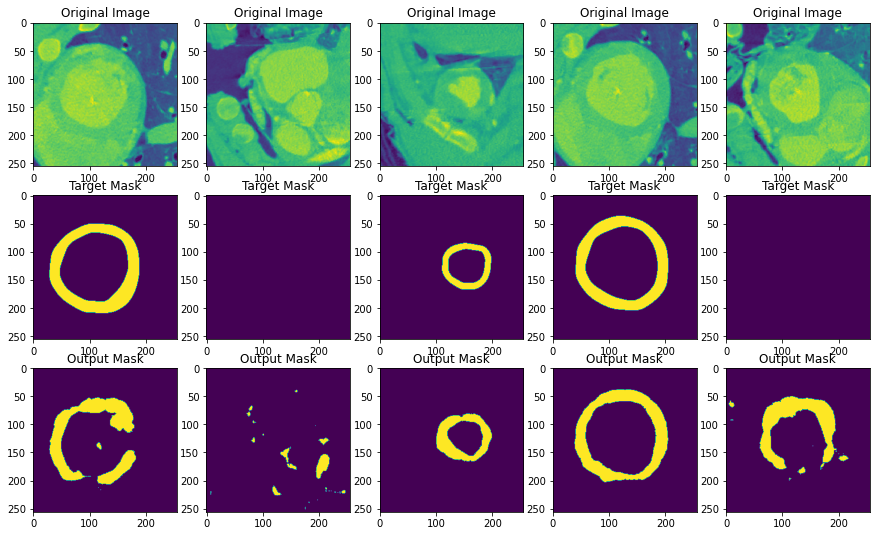

In [11]:
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
slice_depth = 15
for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')
    
    test_image = sample['image'].unsqueeze(0) #.squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(test_mask[:, :, slice_depth])
    np.save('test' + i, test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + model.hparams.name + '.png')

In [ ]:
train_samples = random.sample(range(len(train_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    sample = train_dataset[train_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, 8])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, 8])
    axs[1, i].set_title('Target Mask')
    
    train_image = sample['image'].unsqueeze(0) # .squeeze(4)
    train_mask = model(train_image)
    train_mask = train_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(train_mask[:, :, 8])
    axs[2, i].set_title('Output Mask')

